In [1]:
from simple_back.backtester import BacktesterBuilder

In [2]:
builder = (
   BacktesterBuilder()
   .name('JNUG 20-Day Crossover')
   .balance(10_000)
   .calendar('NYSE')
   .compare(['JNUG']) # strategies to compare with
   .live_progress() # show a progress bar using tqdm
   .live_plot() # we assume we are running this in a Jupyter Notebook
)

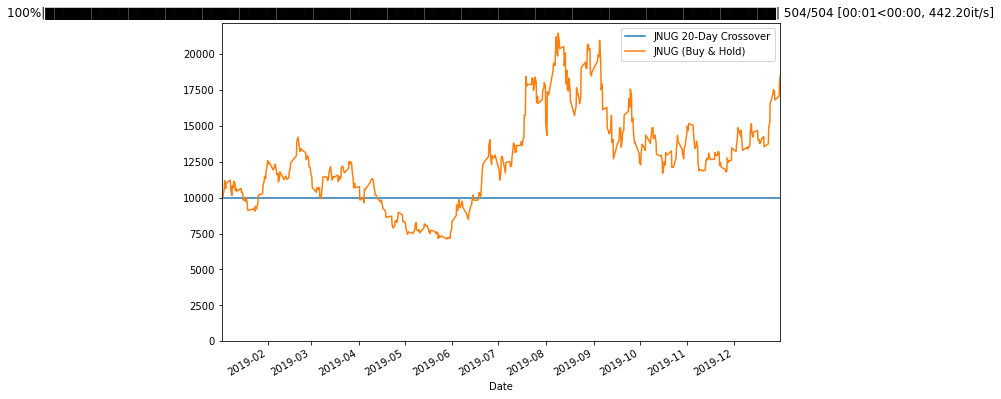

In [3]:
bt = builder.build()
for day, event, b in bt['2019-1-1':'2020-1-1']:
      pass

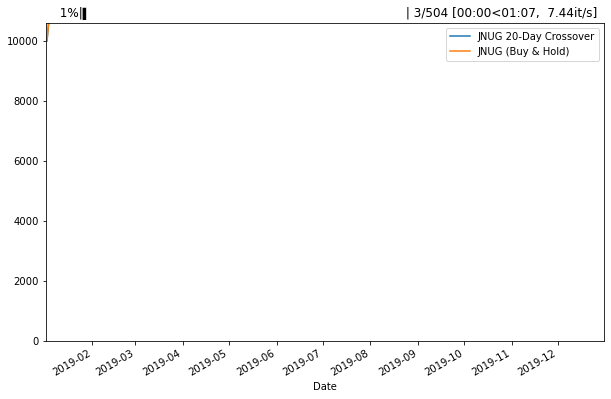

InsufficientCapitalError: 
                        not enough capital available:
                        ordered 1 * 10563.648455632008
                        with only 449.31090733719975 available
                        

In [4]:
bt = builder.build()
for day, event, b in bt['2019-1-1':'2020-1-1']:
    if event == 'open':
        jnug_ma = b.prices['JNUG',-20:]['close'].mean()
        if b.price('JNUG') > jnug_ma:
            b.long('JNUG', percent=1) # as percent of total value
        if b.price('JNUG') < jnug_ma:
            b.short('JNUG', percent=1) # as percent of total value

The above fails with an `.InsufficientCapitalError` because we repeatedly try to invest 100% of our assets into JNUG, even when we already hold JNUG shares.

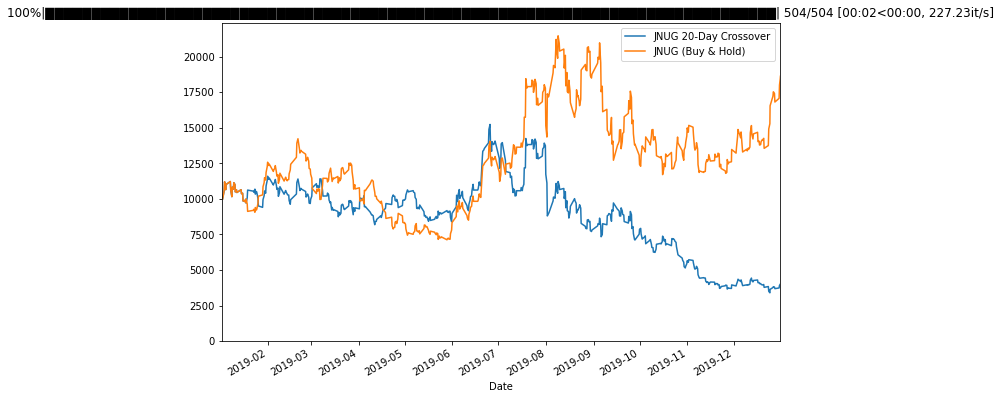

In [5]:
bt = builder.build()
for day, event, b in bt['2019-1-1':'2020-1-1']:
    if event == 'open':
        jnug_ma = b.prices['JNUG',-20:]['open'].mean()
        if b.price('JNUG') > jnug_ma:
            if not b.portfolio['JNUG'].long: # check if we already are long JNUG
                b.portfolio['JNUG'].short.liquidate() # liquidate any/all short JNUG positions
                b.long('JNUG', percent=1) # as percent of total value
        if b.price('JNUG') < jnug_ma:
            if not b.portfolio['JNUG'].short: # check if we already are long JNUG
                b.portfolio['JNUG'].long.liquidate() # liquidate any/all short JNUG positions
                b.short('JNUG', percent=1) # as percent of total value

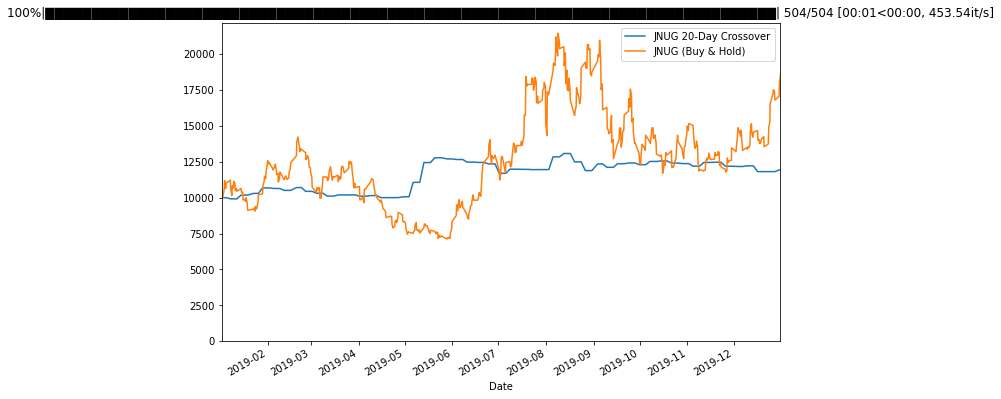

In [6]:
bt = builder.build()
for day, event, b in bt['2019-1-1':'2020-1-1']:
    
    if event == 'open':
        b.portfolio.liquidate()
    if event == 'close' and day.weekday() == 4:
        b.long('VIXY', percent=1) 

In [7]:
from simple_back.strategy import Strategy

In [8]:
class BuyWeekend(Strategy):
    def __init__(self, ticker):
        self.ticker = ticker

    def run(self, day, event, bt):
        if event == 'open':
            bt.portfolio.liquidate()
        if event == 'close' and day.weekday() == 4:
            bt.long(self.ticker, percent=1) 
    @property
    def name(self):
        return f"{self.ticker} (Buy Weekend)"

In [9]:
builder = (
   BacktesterBuilder()
   .balance(10_000)
   .calendar('NYSE')
   .compare([
       BuyWeekend('^GSPC'),
       '^GSPC'
   ])
   .live_plot(every=100) # we assume we are running this in a Jupyter Notebook
)

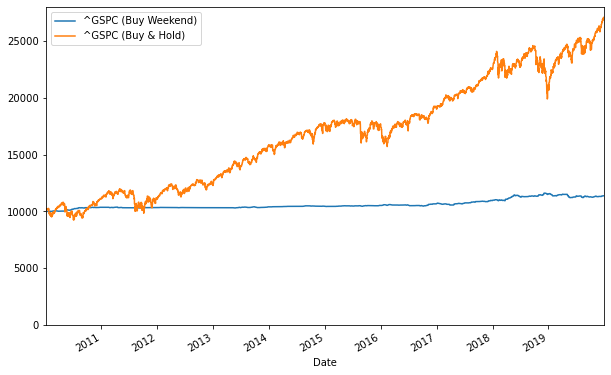

In [10]:
bt = builder.build()
bt['2010-1-1':'2020-1-1'].run()